In [ ]:
import numpy as np
import pandas as pd
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pandas_profiling as pp
import plotly.express as px

# Importando Dados do CSV

In [ ]:
diabetes = pd.read_csv("https://drive.google.com/u/0/uc?id=10maFHghj2UZAoqceTpuMsn9tCcWqTXHS&export=download", low_memory=False)
diabetes.head(100)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,56,Female,Yes,Yes,No,Yes,No,No,Yes,Yes,No,No,Yes,No,No,No,Positive
96,30,Female,Yes,Yes,Yes,Yes,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Positive
97,31,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,Yes,Yes,No,No,Positive
98,35,Female,Yes,Yes,No,No,No,No,Yes,No,No,No,No,No,Yes,No,Positive


# Heatmap de features
Permite a visualização rapida das features mais presentes no dataset. 

Feature HeatMap


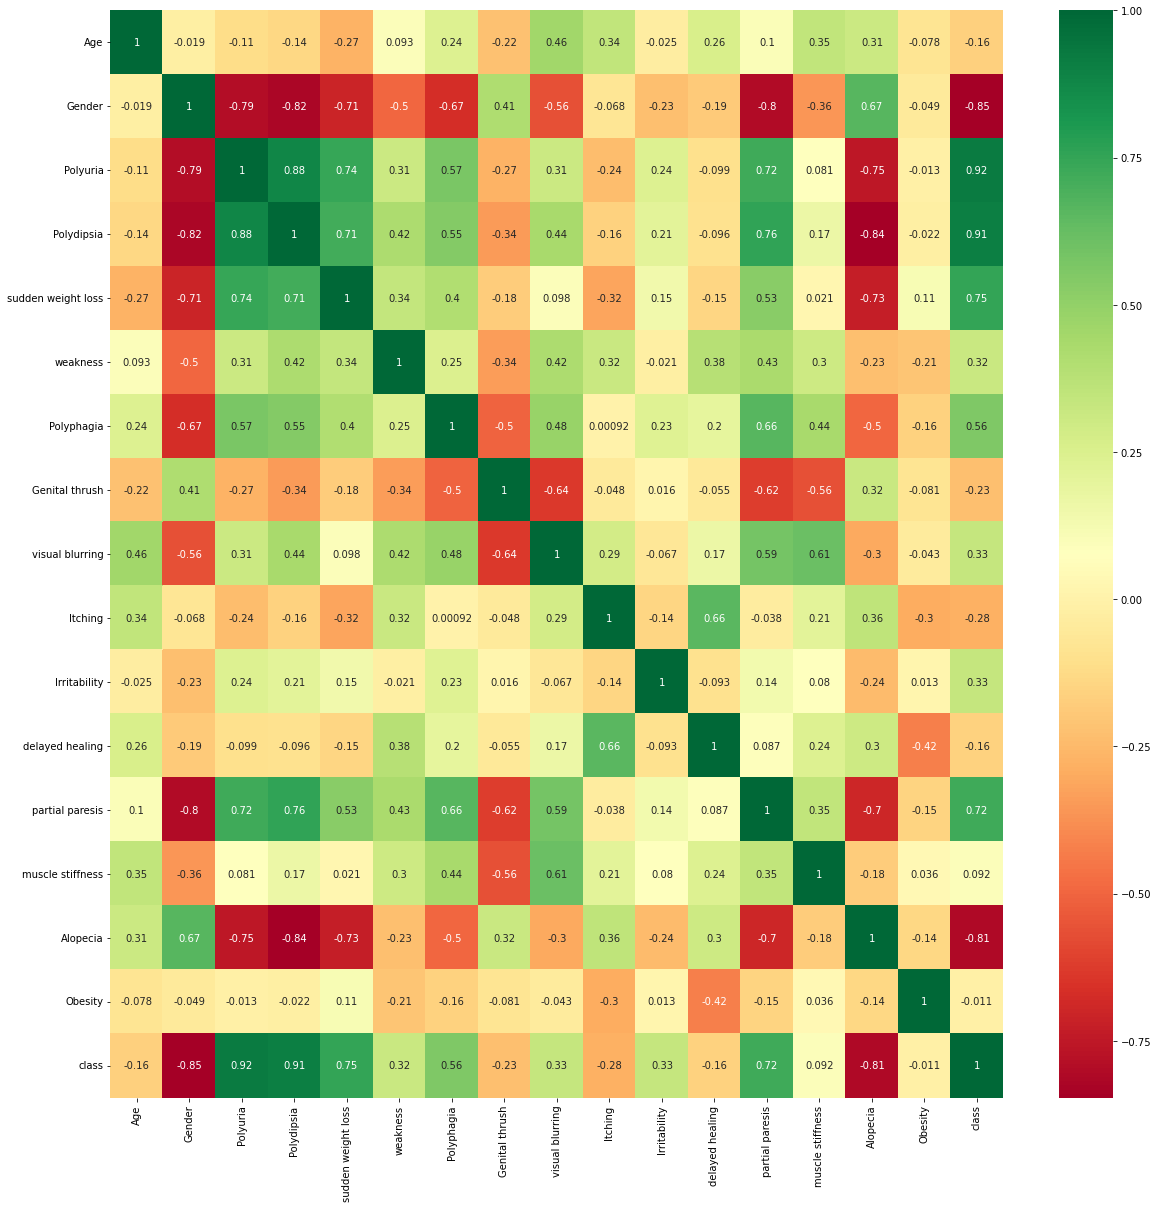

In [ ]:
#Substituindo valores string por binários
diabetes_bin = diabetes.replace(['Male','Female','Yes','No','Positive','Negative'],(1,0,1,0,1,0))
cor_mat = diabetes_bin.corr()
plt.figure(figsize=(20,20))
top_corr_features = cor_mat.index
sns.heatmap(cor_mat[top_corr_features].corr(),annot=True,cmap="RdYlGn")
print('Feature HeatMap')

# Sanitarizando dados

In [ ]:
numeric_cols = diabetes.select_dtypes(include = [np.number]).columns.tolist()
scalar_cols = diabetes.select_dtypes(exclude = [np.number]).columns.tolist()
numeric_cols = diabetes.drop(['class'], axis = 1).select_dtypes(include = [np.number]).columns.tolist()
print('Numeric Columns \n', numeric_cols)
print('Non-Numeric Columns \n', scalar_cols)
diabetes_new_num = diabetes[numeric_cols + ['class']]
# Colunas ecalares
diabetes_new_cat = diabetes[scalar_cols]
diabetes_new_cat.head()

Numeric Columns 
 ['Age']
Non-Numeric Columns 
 ['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']


,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [ ]:
# Normalizando dados utilizando panda dummies
diabetes_new_cat_dummies = pd.get_dummies(diabetes_new_cat)
diabetes_new_cat_dummies.head()

,Gender_Female,Gender_Male,Polyuria_No,Polyuria_Yes,Polydipsia_No,Polydipsia_Yes,sudden weight loss_No,sudden weight loss_Yes,weakness_No,weakness_Yes,Polyphagia_No,Polyphagia_Yes,Genital thrush_No,Genital thrush_Yes,visual blurring_No,visual blurring_Yes,Itching_No,Itching_Yes,Irritability_No,Irritability_Yes,delayed healing_No,delayed healing_Yes,partial paresis_No,partial paresis_Yes,muscle stiffness_No,muscle stiffness_Yes,Alopecia_No,Alopecia_Yes,Obesity_No,Obesity_Yes,class_Negative,class_Positive
0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1
2,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1
3,0,1,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1
4,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


In [ ]:
#concatenando valores dummy com valores originais
diabetes_final = pd.concat([diabetes_new_num, diabetes_new_cat_dummies], axis = 1)
print(diabetes_final.shape)
diabetes_final.head()

(520, 34)


,Age,class,Gender_Female,Gender_Male,Polyuria_No,Polyuria_Yes,Polydipsia_No,Polydipsia_Yes,sudden weight loss_No,sudden weight loss_Yes,weakness_No,weakness_Yes,Polyphagia_No,Polyphagia_Yes,Genital thrush_No,Genital thrush_Yes,visual blurring_No,visual blurring_Yes,Itching_No,Itching_Yes,Irritability_No,Irritability_Yes,delayed healing_No,delayed healing_Yes,partial paresis_No,partial paresis_Yes,muscle stiffness_No,muscle stiffness_Yes,Alopecia_No,Alopecia_Yes,Obesity_No,Obesity_Yes,class_Negative,class_Positive
0,40,Positive,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1
1,58,Positive,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1
2,41,Positive,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1
3,45,Positive,0,1,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1
4,60,Positive,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


In [ ]:
#extrai colunas
columns = diabetes_final.columns.tolist()
print(columns)

['Age', 'class', 'Gender_Female', 'Gender_Male', 'Polyuria_No', 'Polyuria_Yes', 'Polydipsia_No', 'Polydipsia_Yes', 'sudden weight loss_No', 'sudden weight loss_Yes', 'weakness_No', 'weakness_Yes', 'Polyphagia_No', 'Polyphagia_Yes', 'Genital thrush_No', 'Genital thrush_Yes', 'visual blurring_No', 'visual blurring_Yes', 'Itching_No', 'Itching_Yes', 'Irritability_No', 'Irritability_Yes', 'delayed healing_No', 'delayed healing_Yes', 'partial paresis_No', 'partial paresis_Yes', 'muscle stiffness_No', 'muscle stiffness_Yes', 'Alopecia_No', 'Alopecia_Yes', 'Obesity_No', 'Obesity_Yes', 'class_Negative', 'class_Positive']


# Coletando dados de treinamento

In [ ]:
#separando eixos X e Y baseado no campo "class" que indica posivivo ou negativo para diabetes
y = diabetes_bin["class"].to_frame()
X = diabetes_bin.drop(["class"], axis=1)

#declarando variáveis de treinamento
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.21,random_state=1337)

# Árvore de decisão

['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity']


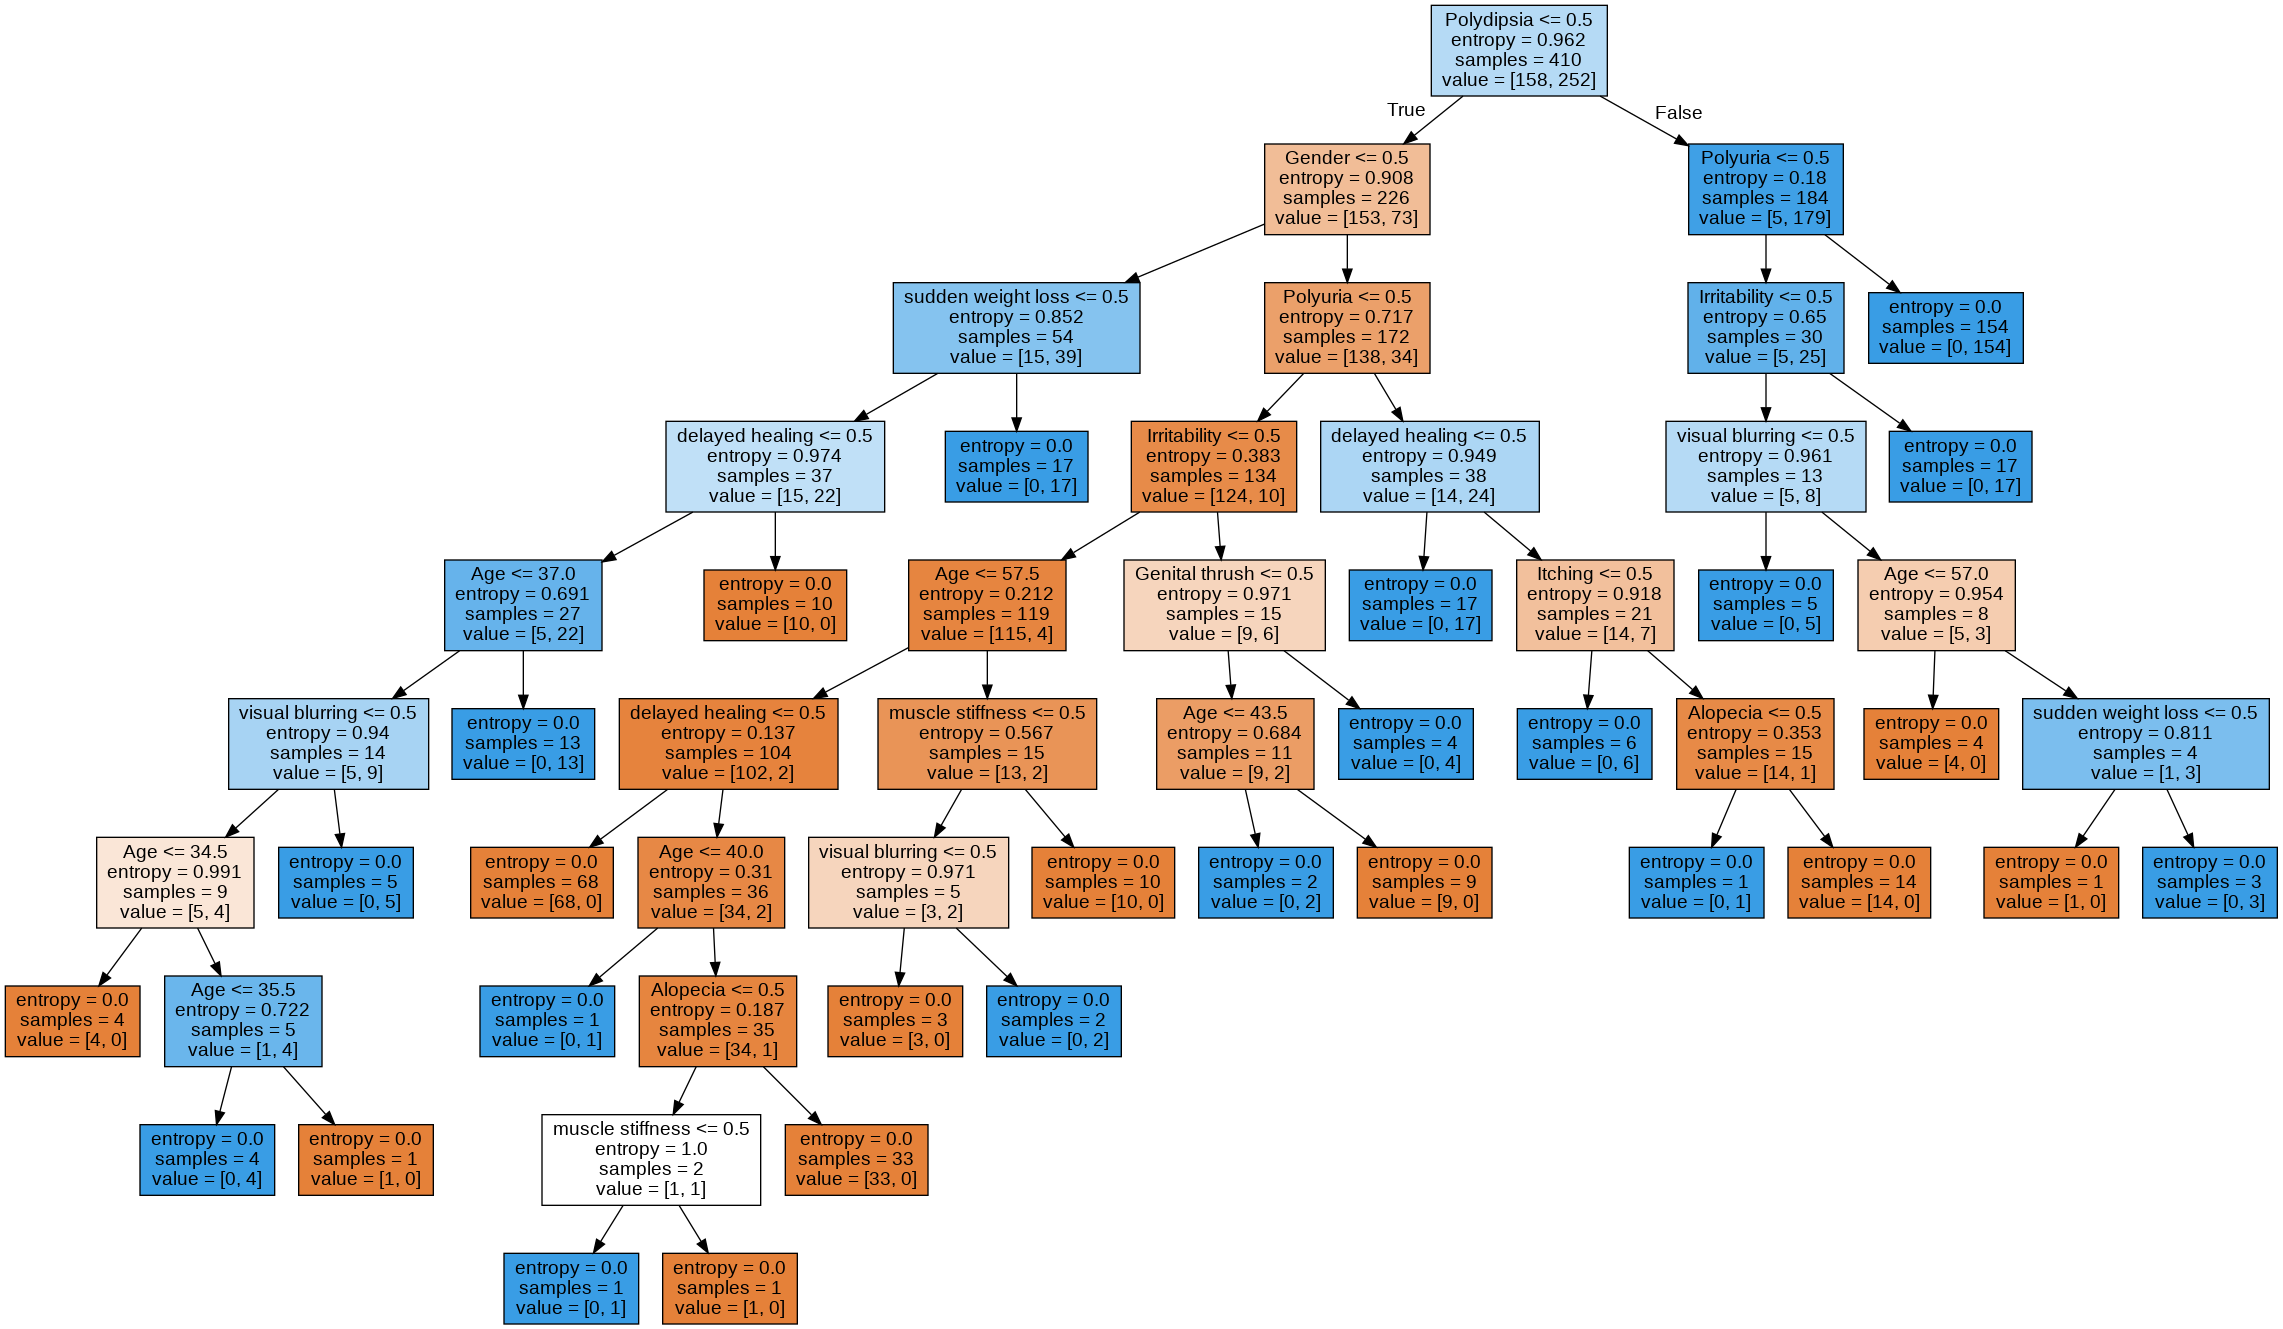

In [ ]:
#aplicando classificador
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 1337)
classifier.fit(X_train, y_train)

#exporta o grafico e captura para uma encoded string
dot_data = StringIO()
feature_columns = diabetes_bin.columns.tolist()[:-1]
print(feature_columns)
export_graphviz(classifier, out_file=dot_data, feature_names=feature_columns, class_names=None, filled=True)

graph, = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Alternativamente, a lib SelectKBest permite a extração das features sem usar árvore de decisão

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



,Scores,Importância (%)
Feature,,
Polydipsia,120.785515,22.198
Polyuria,116.184593,21.353
sudden weight loss,57.749309,10.613
partial paresis,55.314286,10.166
Gender,38.747637,7.121
Irritability,35.334127,6.494
Polyphagia,33.198418,6.101
Alopecia,24.402793,4.485
Age,18.845767,3.464


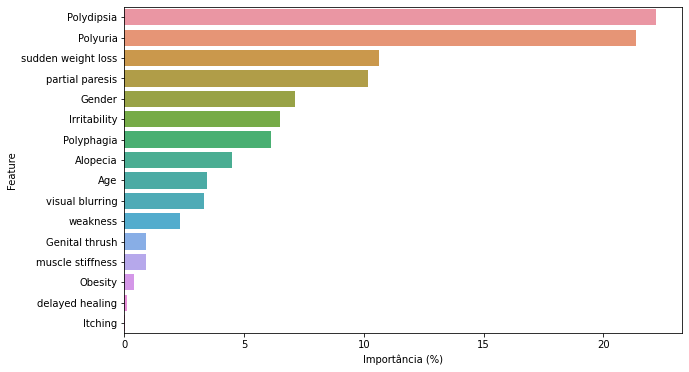

In [ ]:

X = diabetes_bin.drop('class',axis=1)
Y = diabetes_bin['class']
# utiliza a lib SelectKBest para determinar as features com o melhor score K
# A lib utiliza o modelo chi2 que calcula o qui-quadrado. 
# Essa distribuição serve para calcular quantitativamente a relação entre o resultado do dataset e sua a distribuição esperada.
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X, Y)
## monta a array de scores com os valores K transformados para porcentagem
per = []
for i in fs.scores_:
    per.append(round(((i/sum(fs.scores_))*100),3)) # essa indentação do python é mto zoada
##
## cria um dataset no pandas para plotar as features
features_data = pd.DataFrame(
    {
      'Feature':feature_columns,
      'Scores':fs.scores_,
      'Importância (%)':per
    }
).sort_values(by=['Scores'], ascending=False)
## configurações de plotagem utilizando a lib seaborn
plt.figure(figsize=(10,6))
sns.barplot(
              'Importância (%)',
              'Feature',
              orient='h',
              data=features_data
            )
## remover features insignificantes
insignificant = features_data.loc[features_data['Importância (%)']<0.005]['Feature'].unique()
# indexa o dataset
features_data.set_index('Feature')

# Em ambos os casos, a Polidipsia é a feature mais importante. 
Polidipsia é a condição que ocorre quando uma pessoa tem sede excessiva e por causa disso acaba ingerindo quantidade exagerada de água e outros líquidos.
Parece está bem relacionada a diabetes: 
https://www.healthline.com/health/diabetes/3-ps-of-diabetes#polydipsia

# Diagrama de Correlações

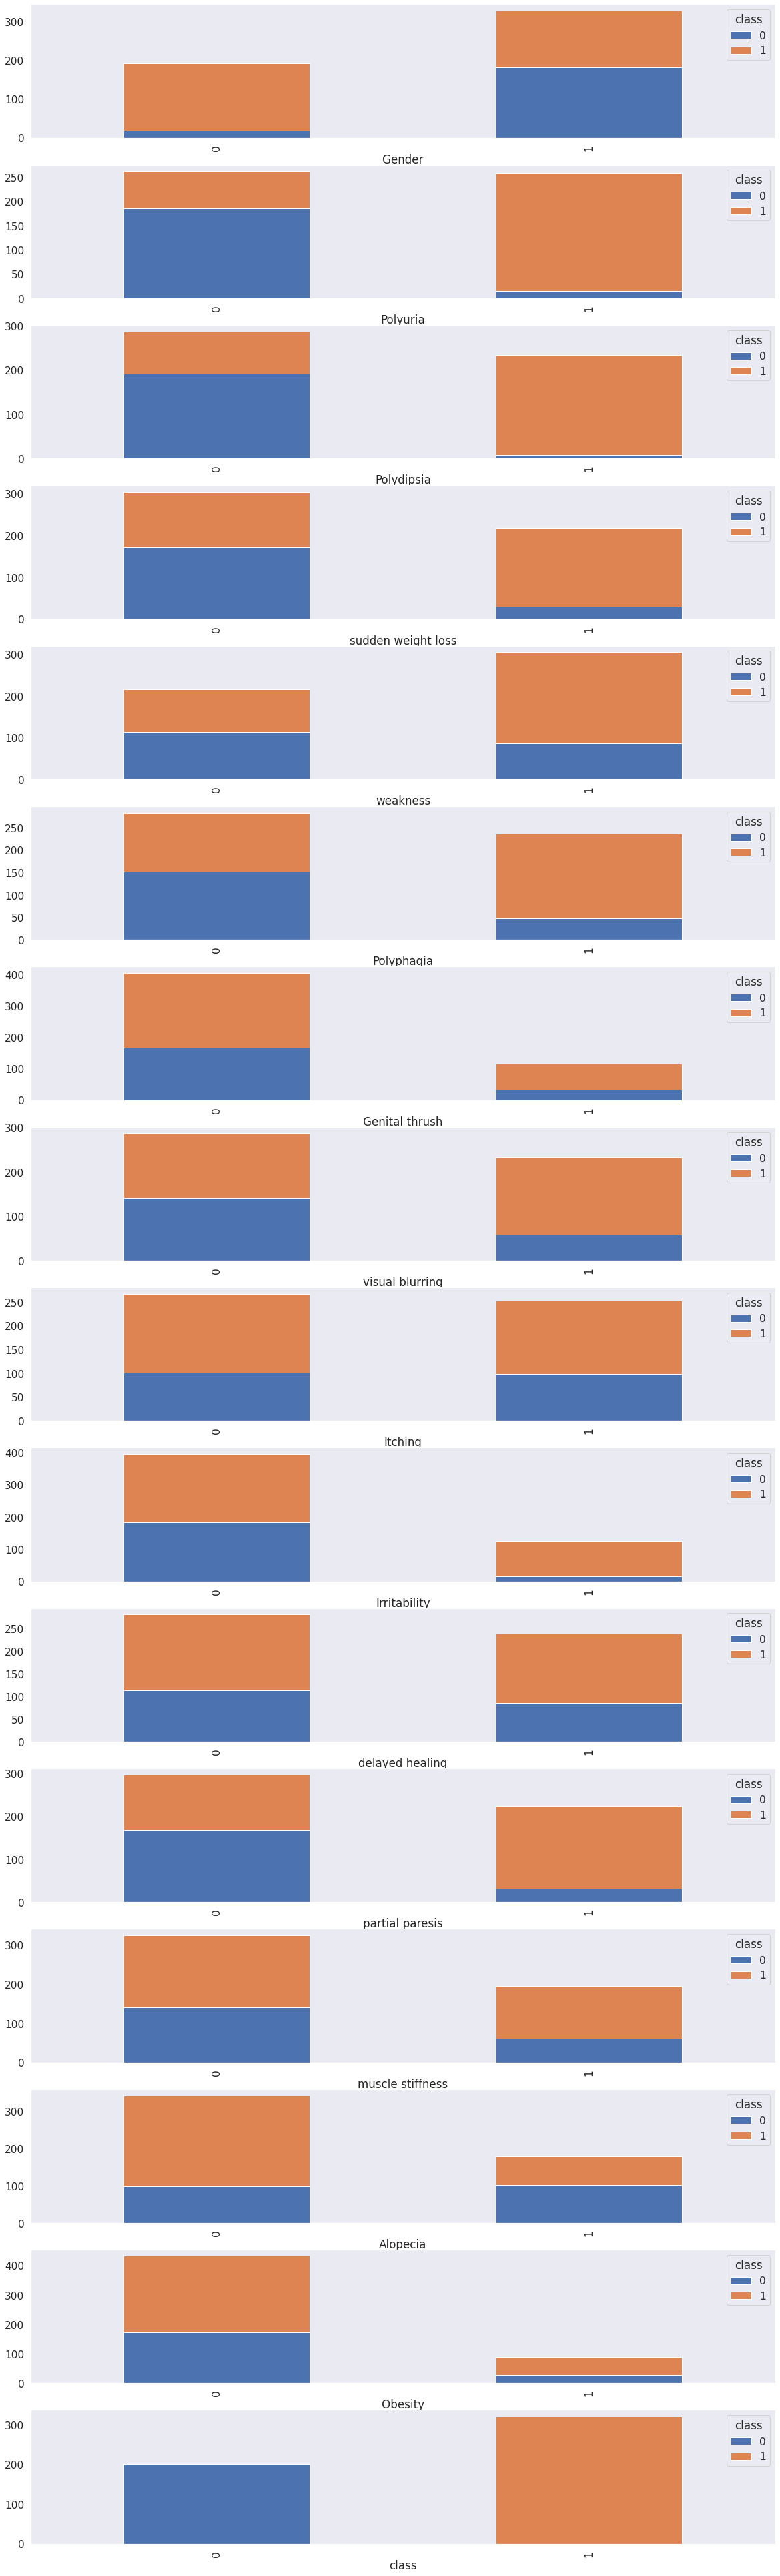

In [ ]:
#utilizando subplots para plotar as correlações onde class = 1 e a feature = 1
obj_cols_viz = scalar_cols
fig, axes = plt.subplots(len(obj_cols_viz), sharex = False, sharey = False, figsize = (20, 70))

for i in range(0, len(obj_cols_viz)):
    pd.crosstab(diabetes_bin[obj_cols_viz[i]], diabetes_bin['class']).plot(kind = 'bar', stacked = True, grid = False, ax = axes[i])

# Correlações entre diabetes e Polidipsia e Poliuria

Correlação entre Polydipsia e Polyuria com diagnóstico positivo:
            Polydipsia  Polyuria   class
Polydipsia      100.00     59.86   64.87
Polyuria         59.86    100.00   66.59
class            64.87     66.59  100.00


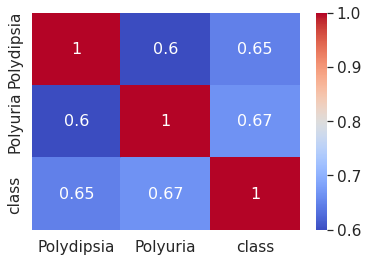

In [ ]:
 correlacao= diabetes_bin[['Polydipsia','Polyuria', 'class']].copy().corr()
sns.heatmap(correlacao, annot = True, cmap = "coolwarm")
print(f'Correlação entre Polydipsia e Polyuria com diagnóstico positivo:\n{(round(100*correlacao,2))}')

# Correlação de gêneros

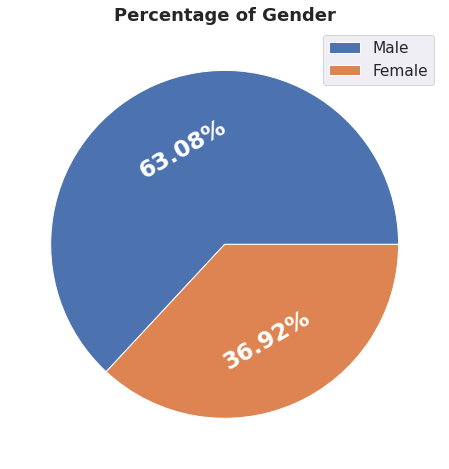

In [ ]:
plt.figure(figsize = (10, 8))
plt.pie(pd.value_counts(diabetes['Gender']), 
        labels = ['Male','Female'],
        autopct = '%.2f%%',
        textprops = {'size' : 'x-large',
                     'fontweight' : 'bold', 
                     'rotation' : '30',
                     'color' : 'w'})

plt.legend()
plt.title('Percentage of Gender', fontsize = 18, fontweight = 'bold')
plt.show()

Correlação entre Feminino e Masculino com diagnóstico positivo:
                Gender_Male  Gender_Male  class_Positive
Gender_Male          100.00       100.00          -44.92
Gender_Male          100.00       100.00          -44.92
class_Positive       -44.92       -44.92          100.00


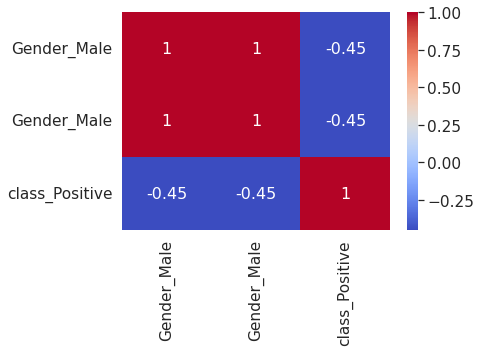

In [ ]:
correlacao = diabetes_final[['Gender_Male','Gender_Male','class_Positive']].copy().corr()
sns.heatmap(correlacao, annot = True, cmap = "coolwarm")
print(f'Correlação entre Feminino e Masculino com diagnóstico positivo:\n{(round(100*correlacao,2))}')

# Correlação com idade

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



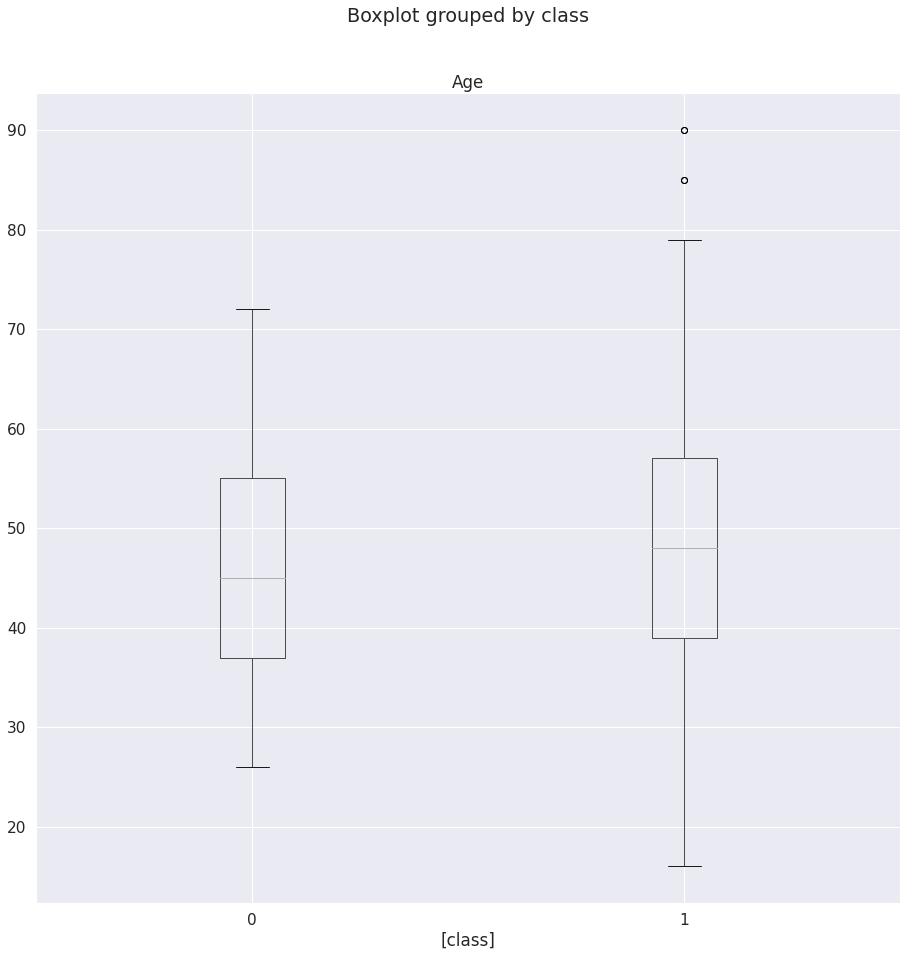

In [ ]:
num_cols_viz = ['Age']

fig, axes = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (15, 15))
diabetes_bin.loc[:, ['class']+num_cols_viz].boxplot(by = 'class', ax = axes, return_type = 'axes');

# Modelos de Classificação

In [ ]:
#separando eixos X e Y baseado no campo "class" que indica posivivo ou negativo para diabetes
X = diabetes_bin.drop(["class"], axis=1)
y = diabetes_bin["class"].to_frame()

training_size = 0.25

#declarando variáveis de treinamento
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=training_size,random_state=42)

In [ ]:
#Regressão Linear
lr = LinearRegression()
#Regressão Logística
lor = LogisticRegression(random_state = 42,solver = 'liblinear')
#Random Forest
rfc = RandomForestClassifier()
#Nearest neighboor
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

In [ ]:
#Adicionando modelos em uma lista
models = [lr,lor,rfc,knn]
# Com os modelos definidos, realizamos o processo de treinamento num laço e obtemos as acurárias para popularmos uma array
acc = [];
for model in models:
    #Como todos os modelos extendem de BaseEstimator, o método fit está disponivel e podemos chamá-los no laço
    model.fit(X_train,y_train)
    #Realiza a predição com o conjunto de teste
    prediction = model.predict(X_test)
    if not acc:
      #A lib accuracy_score não aceita o prediction da regressão linear. Algo a ver com não ser uma métrica de classificação??? então eu fiz esse if bem pythoniano para rodar o score da RL
      score = model.score(X_test,y_test)
    else:
      #Utiliza a lib accuracy_score para testar a acurácia dos modelos de classificação com o dataset de teste
      score = accuracy_score(y_test,prediction)
    acc.append(score)

# Comparando Modelos

In [ ]:
model_names = ["Regressão Linear", "Regressão Logística", "Random Forest", "KNN"] #isso aqui podia ser mais sofisticado mas eu n sei python direito :(
# Cria um dataframe para listar os modelos e suas acurácias
models_result = pd.DataFrame(
    {
        'Models':model_names,
        'Accuracy':acc
    }
)
#Aplica ordenação
models_result = models_result.sort_values(
    by=['Accuracy'],
    ascending=False
)
models_result

,Models,Accuracy
2,Random Forest,0.992308
1,Regressão Logística,0.938462
3,KNN,0.846154
0,Regressão Linear,0.609781


# Matriz de Confusão

In [ ]:
#Redefinindo modelos para remover a regressão linear
models = [lor,rfc,knn]
#array para guardar os resultados da matriz de confusão
cm_results = []
#configs da lib seaborn
sns.set(font_scale=1.4)
#laço para executar a predição e coletar matriz
for model in models:
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  #cria um dataframe para guardar a matriz de confusao
  df_cm = pd.DataFrame(cm, range(2),range(2))
  #adiciona na lista
  cm_results.append(df_cm)

Regressão Logística


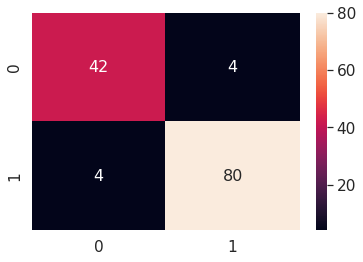

In [ ]:
#Plotando o heatmap de Regressão Logística
sns.heatmap(cm_results[0], annot=True,annot_kws={"size": 16})
print(model_names[1])

Random Forest


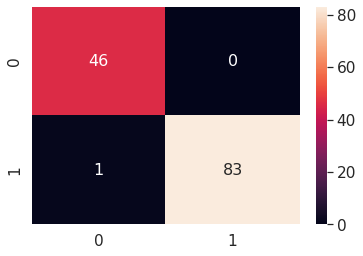

In [ ]:
#Plotando o heatmap de Random Forest
sns.heatmap(cm_results[1], annot=True,annot_kws={"size": 16})
print(model_names[2])

KNN


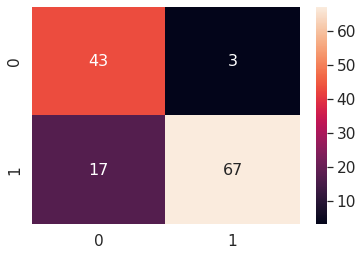

In [ ]:
#Plotando o heatmap de Neearest Neighboor
sns.heatmap(cm_results[2], annot=True,annot_kws={"size": 16})
print(model_names[3])

# ROC Curve
A curva ROC é um gráfico que determina a performance do modelo em todos os limiares de classificação. A curva do área do gráfico, conhecida como AUC determina a performance do modelo. Um valor igual a 0 significa que as predições do modelo estão sempre 100% erradas, enquanto que um valor 1 significa 100% corretas.

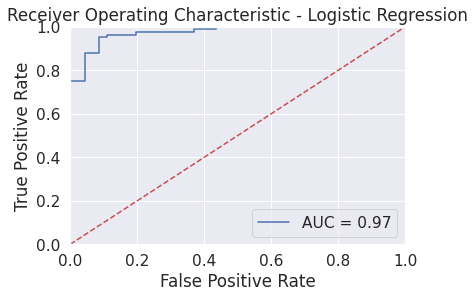

In [ ]:
y_score = lor.decision_function(X_test)

fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_score)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ROC CURVE - Random Forest

Área da curva ROC - Dataset de treinamento: 1.0
Área da curva ROC - Dataset de teste: 1.0
base threadsholds: [2 1]
model threadsholds: [2.   1.   0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.89 0.43 0.34 0.33 0.14
 0.12 0.08 0.06 0.03 0.01 0.  ]


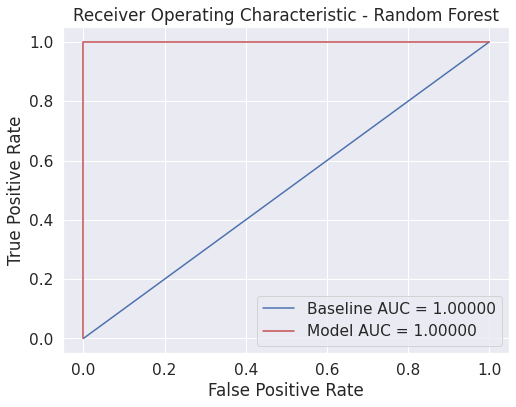

In [ ]:
#como não temos acesso a função decision_function no modelo random forest, é necessário fazer predições utilizando os métodos predict_proba
#calculando scores de predição para o random forest
y_score = rfc.predict_proba(X_train)[:,1] #probabilidades do dataset de treinamento
probs = rfc.predict_proba(X_test)[:, 1] #probabilidades do dataset de teste
train_predictions = rfc.predict(X_train) #predição do dataset de treinamento
#utilizando lib para calcular a área da curva ROC
train_roc_auc = roc_auc_score(y_train, y_score)
test_roc_auc = roc_auc_score(y_test, probs)
print(f'Área da curva ROC - Dataset de treinamento: {train_roc_auc}')
print(f'Área da curva ROC - Dataset de teste: {test_roc_auc}')
#obtendo curva ROC baseado nos dados de teste e treinamento
base_fpr, base_tpr, base_thresholds = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, model_thresholds = roc_curve(y_test, probs)
print(f'base threadsholds: {base_thresholds}')
print(f'model threadsholds: {model_thresholds}')
## plotagem
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
#curva base
plt.plot(base_fpr, base_tpr, 'b', label = 'Baseline AUC = %0.5f' % train_roc_auc)
#curva do modelo
plt.plot(model_fpr, model_tpr, 'r', label = 'Model AUC = %0.5f' % test_roc_auc)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.show();

# Regressão Logística

In [ ]:
# Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

##
classifier = LogisticRegression(random_state = 42,solver = 'liblinear')
classifier.fit(X_train, y_train.values.ravel())
y_pred = classifier.predict(X_train)
train_pred = classifier.predict(X_train)
test_pred = classifier.predict(X_test)
print('Classificação - Treinamento: \n',
      classification_report(y_train, train_pred))
print('Classificação - Teste: \n',
      classification_report(y_test, test_pred))

Classificação - Treinamento: 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       154
           1       0.96      0.91      0.94       236

    accuracy                           0.93       390
   macro avg       0.92      0.93      0.92       390
weighted avg       0.93      0.93      0.93       390

Classificação - Teste: 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        46
           1       0.95      0.95      0.95        84

    accuracy                           0.94       130
   macro avg       0.93      0.93      0.93       130
weighted avg       0.94      0.94      0.94       130



In [ ]:
fig = px.scatter(x=X_train['Polydipsia'], y=y_pred, trendline="ols", labels={'x':'Polydipsia', 'y':'Prediction Data'})
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
fig = px.scatter(x=X_train['Polyuria'], y=y_pred, trendline="ols", labels={'x':'Polyuria', 'y':'Prediction Data'})
fig.show()

In [ ]:
#separando eixos X e Y baseado no campo "class" que indica posivivo ou negativo para diabetes
X = diabetes_final.drop(['class'], axis = 1)
y = diabetes_final['class']

training_size = 0.1

#declarando variáveis de treinamento
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=training_size,random_state=42)

#escalando dados
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

##
classifier = LogisticRegression(random_state = 42,solver = 'liblinear')
classifier.fit(X_train, y_train.values.ravel())
y_pred = classifier.predict(X_train)
train_pred = classifier.predict(X_train)
test_pred = classifier.predict(X_test)
print('Classificação - Treinamento: \n',
      classification_report(y_train, train_pred))
print('Classificação - Teste: \n',
      classification_report(y_test, test_pred))

Classificação - Treinamento: 
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       179
    Positive       1.00      1.00      1.00       289

    accuracy                           1.00       468
   macro avg       1.00      1.00      1.00       468
weighted avg       1.00      1.00      1.00       468

Classificação - Teste: 
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        21
    Positive       1.00      1.00      1.00        31

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



# Random Forest

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



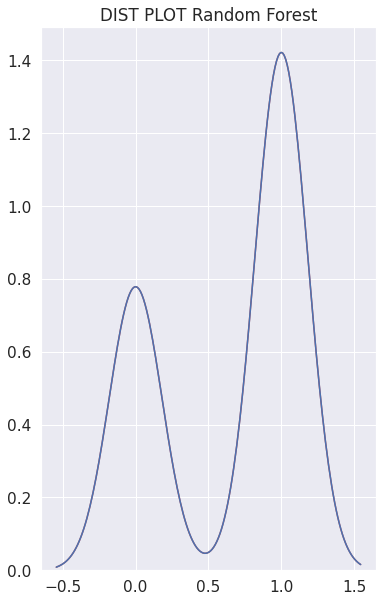

In [ ]:
from sklearn import tree
#separando eixos X e Y baseado no campo "class" que indica posivivo ou negativo para diabetes
X = diabetes_final.drop(['class'], axis = 1)
y = diabetes_final['class']

training_size = 0.25

#declarando variáveis de treinamento
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=training_size,random_state=42)

#escalando dados
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

##
clf = RandomForestClassifier(max_depth=5,random_state=0)
clf.fit(X_train,y_train)
pred_random = clf.predict(X_test)
pred_random2 = clf.predict(X_train)
plt.figure(figsize=(6, 10))
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(pred_random, hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.title('DIST PLOT Random Forest')
plt.xlabel('')
plt.ylabel('')
plt.show()
plt.close()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



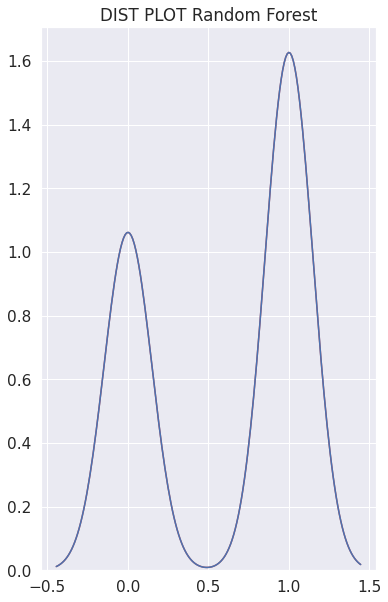

In [ ]:
plt.figure(figsize=(6, 10))
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(pred_random2, hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.title('DIST PLOT Random Forest')
plt.xlabel('')
plt.ylabel('')
plt.show()
plt.close()

# Análise do treinamento

*   A normalização de dados através de dummies (variavel diabetes_final) nao produziu modelos suficientemente confiáveis, sendo utilizado a normalização simples (substituição de 1,0 na variavel diabetes_bin na construção dos modelos)
*   A análise de acurácia dos modelos demonstra que a Regressão Logística foi o melhor resultado. 
*   Curva de ROC e a matriz de confusão demonstram que o modelo de RandomForest apresenta um over-fitting alto
*   Não consegui utilizar a lib de plotagem para fazer o scattering do resultado dos treinamentos. O gráfico chegou a plotar, mas os scatterings estão estranhos.
*   As mulheres são mais propensas a ter diabetes do que os homens.
*   Pessoas com poliúria são mais propensas a ter diabetes do que aquelas que não têm poliúria.
*   Pessoas com polidipsia são mais propensas a ter diabetes do que aquelas sem polidipsia.
*   O gráfico boxplot mostra que quanto maior a Idade, maior a chance de uma pessoa ter Diabetes.

